In [3]:
# standard python utilities
import os
from os.path import exists, join, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [8]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

git_dir = join(doc_dir, 'GitHub')
py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'

gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'


In [9]:
m_domain = gpd.read_file(gwfm_dir+'/DIS_data\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

In [10]:
hob_dir = gwfm_dir+'/HOB_data'
ghb_dir = gwfm_dir+'/GHB_data'

## Periodic DWR Groundwater Measurements

In [16]:
stations = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/stations.csv')
perf = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/perforations.csv')
stations = stations.merge(perf)

periodic = pd.read_csv(ghb_dir+'/periodic_gwl_bulkdatadownload/measurements.csv')

stations_gpd = gpd.GeoDataFrame(stations, 
                                geometry = gpd.points_from_xy( stations.LONGITUDE, stations.LATITUDE), crs = 'epsg:4326')

# need to use the domain in lat, long crs as some wells may edge in utm zone 11n
stations_gpd = gpd.sjoin(stations_gpd,m_domain.to_crs('epsg:4326'), how = 'inner', op = 'intersects')
# stations_gpd convert to domain crs
stations_gpd = stations_gpd.to_crs('epsg:32610')

# join the periodic measurements with the site locations 
domain_periodic_gpd = stations_gpd.merge(periodic, on = ['STN_ID','SITE_CODE'])
domain_periodic = periodic.merge(stations_gpd, on = ['STN_ID','SITE_CODE'])

# set the measurement date as the index for data filtering
domain_periodic_gpd['MSMT_DATE']=pd.to_datetime(domain_periodic_gpd['MSMT_DATE'])
domain_periodic_gpd = domain_periodic_gpd.set_index('MSMT_DATE')

domain_periodic['MSMT_DATE']=pd.to_datetime(domain_periodic['MSMT_DATE'])
domain_periodic = domain_periodic.set_index('MSMT_DATE')
domain_periodic = domain_periodic.sort_index()

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


KeyError: 'STN_ID'

In [ ]:
strt_date ='2010-01-01'
end_date = '2019-12-31'
# filter out recent 10 years of data
# most useful format is dataframe with actual date, accuracy, wsel and rpe/dtw for easy format changing
# should not upscale to monthly because we want to capture when the measurement actually happened
domain_periodic_2010s = domain_periodic.loc[strt_date:end_date]
domain_periodic_2010s = domain_periodic_2010s.sort_index()

domain_periodic_2010s.to_csv(hob_dir+'/dwr_gwe_data_2010s.csv')


In [ ]:
domain_periodic_2010s.filter(['SITE_CODE', 'WSE', 'RPE_WSE','WLM_RPE','WLM_GSE',
                              'WLM_ACC', 'WLM_ACC_DESC','LATITUDE','LONGITUDE','WELL_DEPTH'],axis=1)

In [ ]:
domain_periodic_2010s.WLM_ACC.unique(), domain_periodic.WLM_ACC.unique()

## UCD Continuous GW Measurements

In [20]:
# ucd water surface elevation data is in units of meters
ucd_wells = pd.read_csv(hob_dir+'/AllSets.csv', index_col='dt',parse_dates=True)
ucd_meta = pd.read_csv(hob_dir+'/CosumnesRiverPreserve_MW_screened_interval.csv')

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_119900\1389073420.py:2: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ucd_wells = pd.read_csv(hob_dir+'/AllSets.csv', index_col='dt',parse_dates=True)


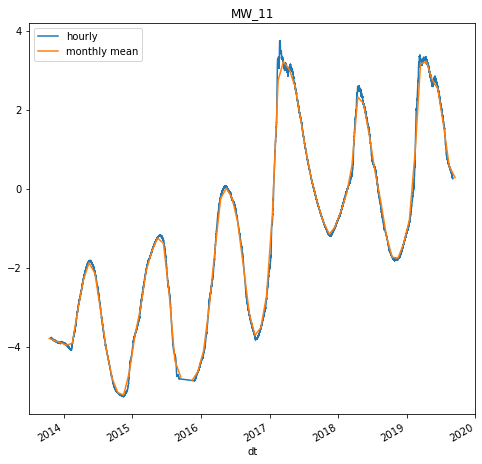

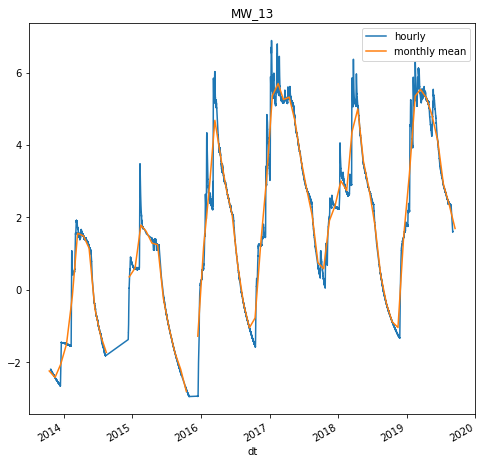

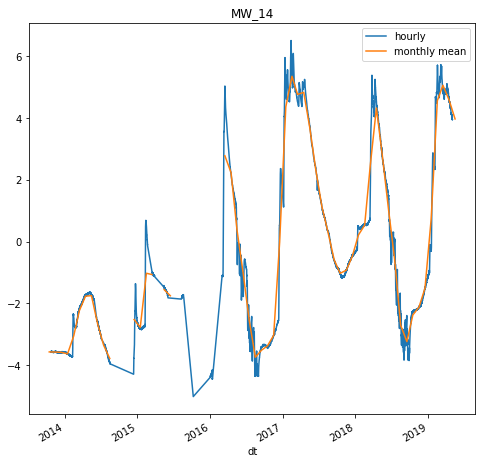

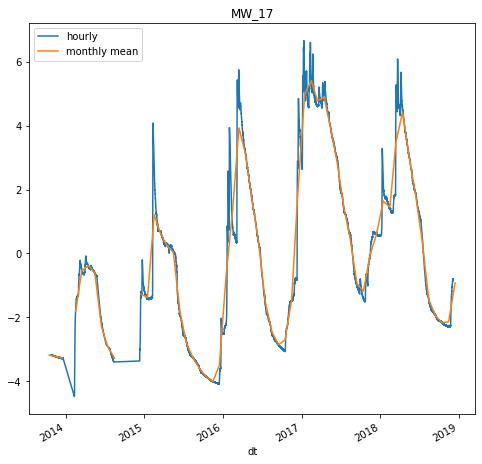

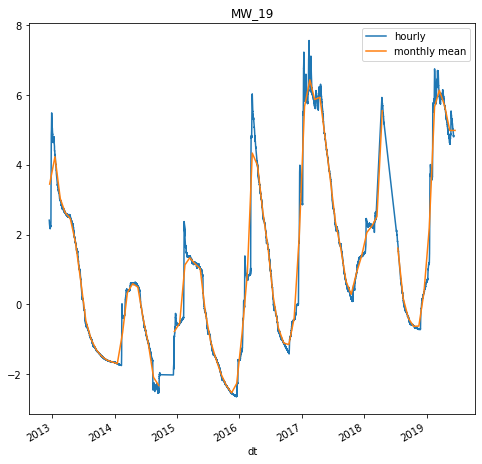

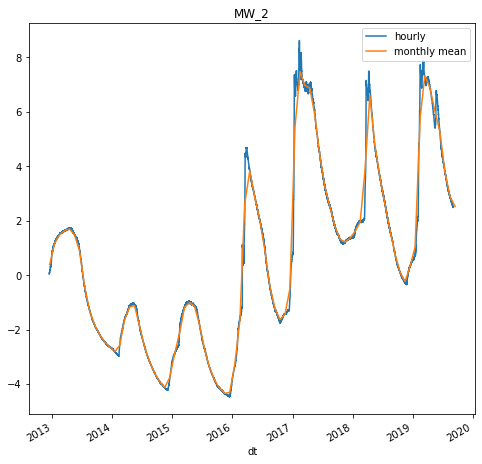

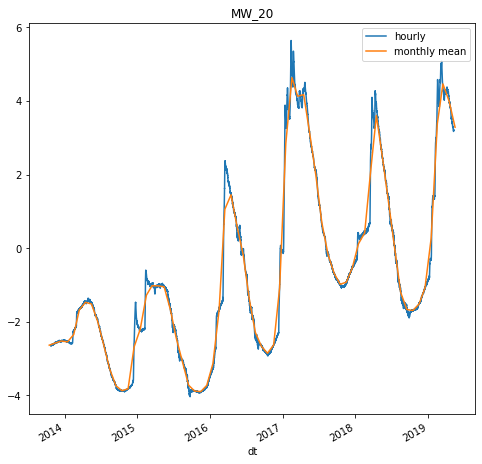

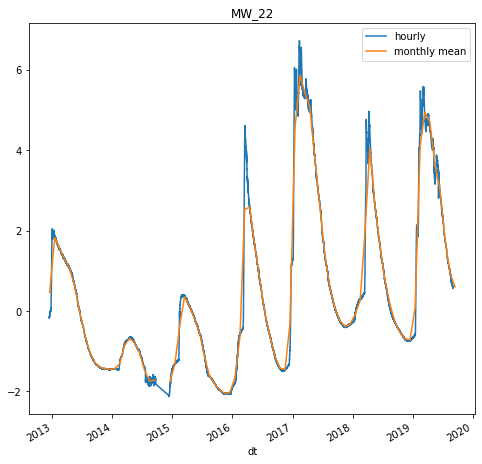

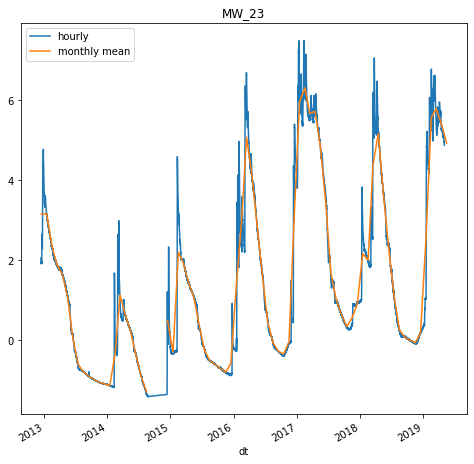

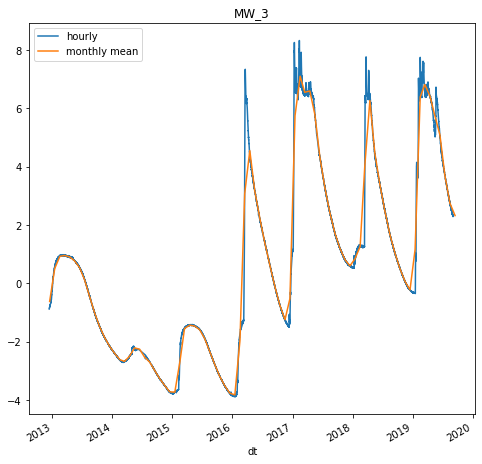

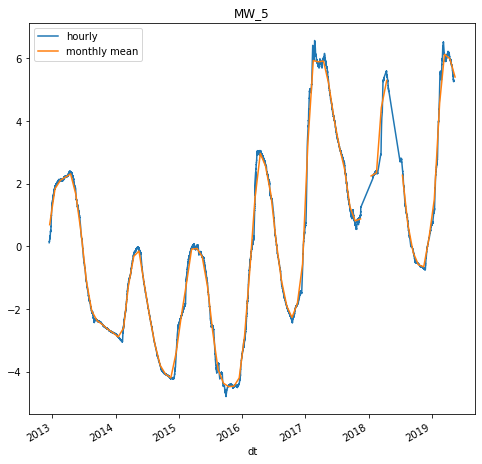

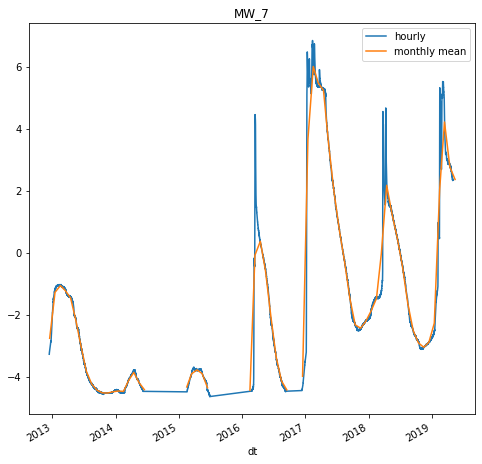

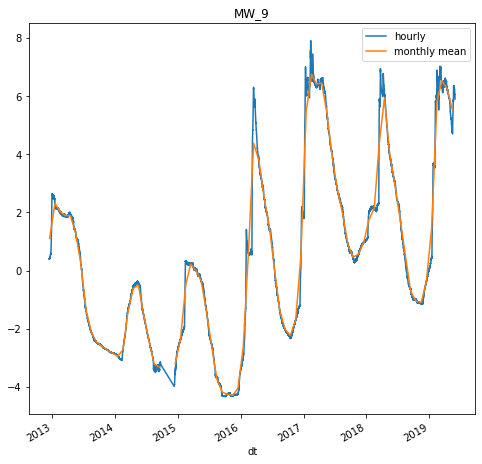

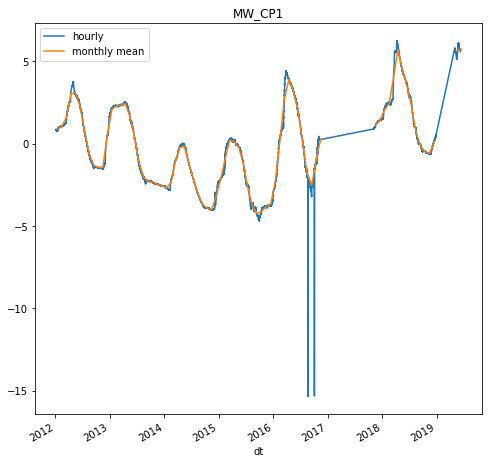

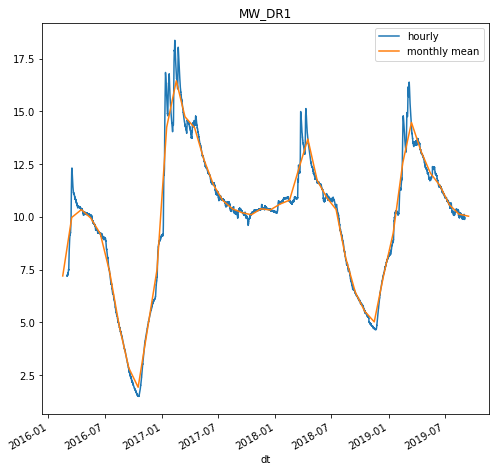

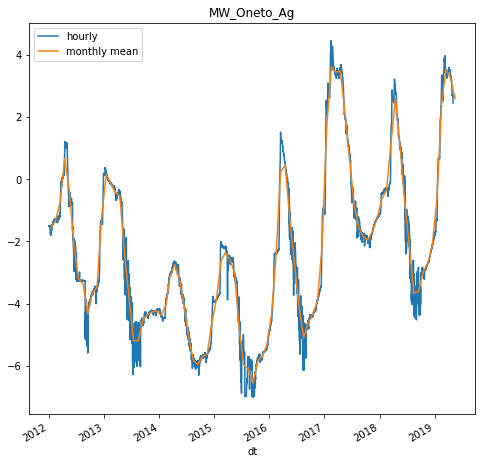

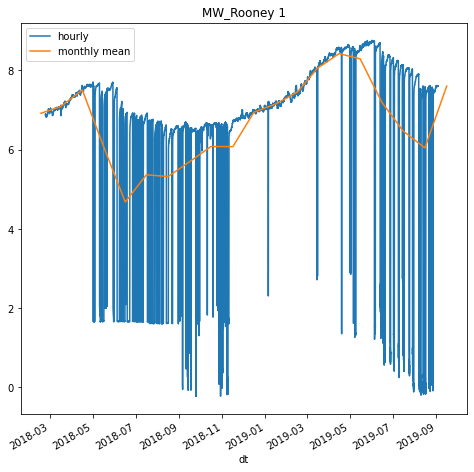

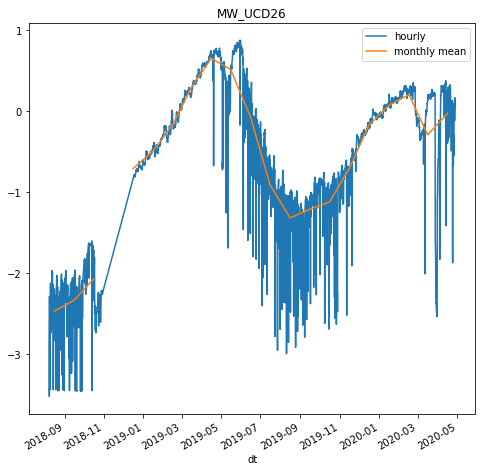

In [189]:
# visually speaking monthly means do a pretty good job of capturing the groundwater hydrograph
# they do miss some key peaks in the flood season by 1-2 meters

for mw in ucd_wells.columns:
    test = ucd_wells[mw]
    test = test.dropna()
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(mw)
    # original data
    test.plot(ax=ax,label = 'hourly')

    # resample daily data to monthly, at month start
    test_mon = test.resample('MS').mean()
    # add 15 days to month start to get to middle of month to avoid data offset
    test_mon.index = test_mon.index+pd.DateOffset(days=15)
    test_mon.plot(ax=ax,label = 'monthly mean')
    plt.legend()
    plt.show()

Monthly mean values represented the major changes in the groundwater hydrograph well,
only missing some peaks by 1-2m. Attempting to use a method that captures the extremes 
by looking at a difference of 0.01m between steps results in ~1000s of data points while
the monthly mean results in ~100 data points per well. Another method such as that use by TSPROC could be developed 
that doesn't look at just change in GWE but targets the extreme points

In [194]:
# resample daily data to monthly, at month start, using mean which is a close approximation
ucd_mon = ucd_wells.resample('MS').mean()
# add 15 days to month start to get to middle of month to avoid data offset
ucd_mon.index = ucd_mon.index+pd.DateOffset(days=15)
ucd_mon.to_csv(hob_dir+'/ucd_wells_monthly.csv')